In [58]:
import numpy as np
import pandas as pd
import emoji
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Embedding
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix

In [59]:
data = pd.read_csv("emoji_data.csv", header=None)
data.head()

,0,1
0,French macaroon is so tasty,4
1,work is horrible,3
2,I am upset,3
3,throw the ball,1
4,Good joke,2


In [60]:
emoji_dictionary = {
    0: ":red_heart:",
    1: ":baseball:",
    2: ":grinning_face_with_big_eyes:",
    3: ":disappointed_face:",
    4: ":fork_and_knife_with_plate:"
}

def label_to_emoji(label):
    return emoji.emojize(emoji_dictionary[label])

In [61]:
X = data[0].values
Y = data[1].values

Y

array([4, 3, 3, 1, 2, 1, 4, 3, 4, 1, 3, 3, 2, 2, 4, 3, 2, 3, 3, 1, 3, 2,
       2, 2, 0, 1, 0, 4, 2, 0, 2, 0, 0, 3, 4, 0, 2, 1, 3, 1, 0, 4, 0, 3,
       0, 4, 2, 3, 4, 2, 2, 3, 0, 2, 2, 3, 2, 3, 2, 2, 3, 3, 0, 2, 3, 0,
       2, 0, 0, 2, 3, 2, 4, 1, 3, 3, 0, 0, 3, 2, 0, 3, 0, 2, 2, 4, 2, 2,
       0, 0, 2, 3, 0, 4, 2, 1, 2, 3, 3, 2, 3, 0, 3, 0, 2, 0, 2, 3, 4, 3,
       1, 3, 4, 3, 2, 3, 3, 3, 1, 4, 4, 2, 2, 1, 1, 2, 3, 2, 3, 4, 2, 3,
       0, 2, 0, 0, 4, 3, 4, 2, 3, 2, 3, 4, 2, 1, 2, 4, 3, 1, 3, 2, 3, 2,
       2, 3, 3, 2, 4, 0, 0, 0, 3, 0, 0, 1, 1, 2, 2, 2, 0, 3, 2, 3, 3, 1,
       2, 2, 4, 2, 3, 1, 2], dtype=int64)

Embeddings

In [62]:
with open('data/glove_dataset/glove.6B.100d.txt','r', encoding='utf8') as file:
    content = file.readlines()

In [46]:
embeddings = {}

for line in content:
    line = line.split()
    embeddings[line[0]] = np.array(line[1:], dtype=float)

convert input text into tokens

In [47]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
word_to_index = tokenizer.word_index


In [48]:
Xtokens = tokenizer.texts_to_sequences(X)


In [49]:
def get_maxlen(data):
    maxlen = 0
    for sent in data:
        maxlen = max(maxlen, len(sent))
    
    return maxlen
maxlen = get_maxlen(Xtokens)

In [50]:
Xtrain = pad_sequences(Xtokens, maxlen = maxlen, padding = 'post', truncating = 'post')

In [51]:
Ytrain = to_categorical(Y)

Model

In [52]:
embed_size = 100

In [53]:
embedding_matrix = np.zeros((len(word_to_index)+1, embed_size))

for word, i in word_to_index.items():
    embed_vector = embeddings[word]
    embedding_matrix[i] = embed_vector

In [54]:
model = Sequential([
    Embedding(input_dim = len(word_to_index)+1,
              output_dim = embed_size,
              input_length=maxlen,
              weights = [embedding_matrix],
              trainable = False
              ),
    LSTM(units = 16, return_sequences=True),
    LSTM(units = 4),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [63]:
model.fit(Xtrain, Ytrain, epochs=100)

Epoch 1/100
6/6 [==============================] - 12s 20ms/step - loss: 1.5868 - accuracy: 0.3497
Epoch 2/100
6/6 [==============================] - 0s 19ms/step - loss: 1.5647 - accuracy: 0.3005
Epoch 3/100
6/6 [==============================] - 0s 26ms/step - loss: 1.5459 - accuracy: 0.3115
Epoch 4/100
6/6 [==============================] - 0s 28ms/step - loss: 1.5306 - accuracy: 0.3115
Epoch 5/100
6/6 [==============================] - 0s 52ms/step - loss: 1.5132 - accuracy: 0.3169
Epoch 6/100
6/6 [==============================] - 0s 23ms/step - loss: 1.4954 - accuracy: 0.3333
Epoch 7/100
6/6 [==============================] - 0s 23ms/step - loss: 1.4740 - accuracy: 0.3825
Epoch 8/100
6/6 [==============================] - 0s 21ms/step - loss: 1.4478 - accuracy: 0.3989
Epoch 9/100
6/6 [==============================] - 0s 23ms/step - loss: 1.4170 - accuracy: 0.3934
Epoch 10/100
6/6 [==============================] - 0s 23ms/step - loss: 1.3852 - accuracy: 0.4754
Epoch 11/100
6/6 [

In [55]:
test = ["I am trying", "I want to cry", "This is just sad"]
true_labels = [3,3,3]

test_seq = tokenizer.texts_to_sequences(test)
Xtest = pad_sequences(test_seq, maxlen=maxlen, padding='post', truncating='post')


y_pred = model.predict(Xtest)
y_pred = np.argmax(y_pred, axis=1)
y_pred

1/1 [==============================] - 10s 10s/step


array([1, 2, 3], dtype=int64)

In [56]:
for i in range(len(test)):
    print(test[i], label_to_emoji(y_pred[i]))

I am trying ⚾
I want to cry 😃
This is just sad 😞


Confusion Matrix

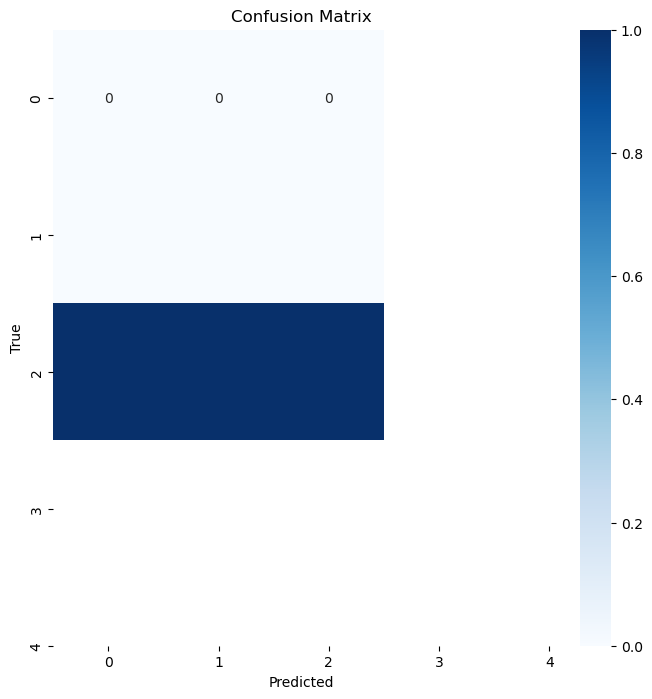

In [65]:

cm = confusion_matrix(true_labels, y_pred)

emoji_labels = [label_to_emoji(i) for i in range(5)]

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=emoji_dictionary, yticklabels=emoji_dictionary)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()